In [1]:
!git clone https://github.com/parhamzm/German-Traffic-Signs-Dataset-GTSRB

Cloning into 'German-Traffic-Signs-Dataset-GTSRB'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 51937 (delta 0), reused 2 (delta 0), pack-reused 51934
Receiving objects: 100% (51937/51937), 299.45 MiB | 14.70 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (51891/51891), done.


In [2]:
!ls German-Traffic-Signs-Dataset-GTSRB

LICENSE  Meta.csv   signnames.csv  Test.csv  Train.csv
Meta	 README.md  Test	   Train


In [0]:
import os
import glob
import random
from PIL import Image
import os.path
import sys


import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import random_split

import torch.nn.functional as F

In [4]:
CUDA = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Cuda : => ", CUDA)

Cuda : =>  cuda:0


In [5]:
DATA_DIR = "German-Traffic-Signs-Dataset-GTSRB/"

batch_size = 300
image_size = 30


os.listdir(DATA_DIR)


['Meta',
 'signnames.csv',
 'LICENSE',
 'Test',
 'Train.csv',
 'Test.csv',
 'README.md',
 'Meta.csv',
 '.git',
 'Train']

In [0]:
train_dir = f'{DATA_DIR}Train'
test_dir = f'{DATA_DIR}Test'
# os.listdir(train_dir)

In [7]:
trn_fnames = glob.glob(f'{train_dir}/*/*.png')
trn_fnames[:5]

['German-Traffic-Signs-Dataset-GTSRB/Train/16/00016_00013_00005.png',
 'German-Traffic-Signs-Dataset-GTSRB/Train/16/00016_00001_00010.png',
 'German-Traffic-Signs-Dataset-GTSRB/Train/16/00016_00005_00009.png',
 'German-Traffic-Signs-Dataset-GTSRB/Train/16/00016_00009_00013.png',
 'German-Traffic-Signs-Dataset-GTSRB/Train/16/00016_00005_00004.png']

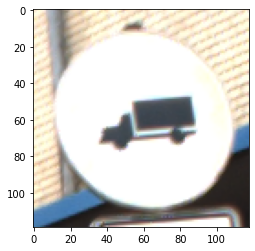

In [8]:
img = plt.imread(trn_fnames[300])
plt.imshow(img);

In [0]:
from torchvision.datasets import ImageFolder
# from torchvision.datasets import VisionDataset

class ImageFolderNew(ImageFolder):
    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.

        Args:
            dir (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.

        Ensures:
            No class is a subdirectory of another.
        """
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort(key=int)
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx


In [10]:
tfms = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = ImageFolderNew(root=train_dir, transform=tfms)

print("Classes in Train DataSet : => ", train_dataset.classes, "\n")
print("Classes in Train DataSet : => ", train_dataset.class_to_idx)

train_loader1 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)

Classes in Train DataSet : =>  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42'] 

Classes in Train DataSet : =>  {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}


In [11]:
data_iter = iter(train_loader1) # it creates an object that allows us to throw the ittrable training loader one element at a time
images, labels = data_iter.next() # it will grab the first batch of our training data
print("X_train : ", images.shape)
print("y_train : ", labels.shape)
X_train = images
y_train = labels

X_train :  torch.Size([2000, 3, 30, 30])
y_train :  torch.Size([2000])


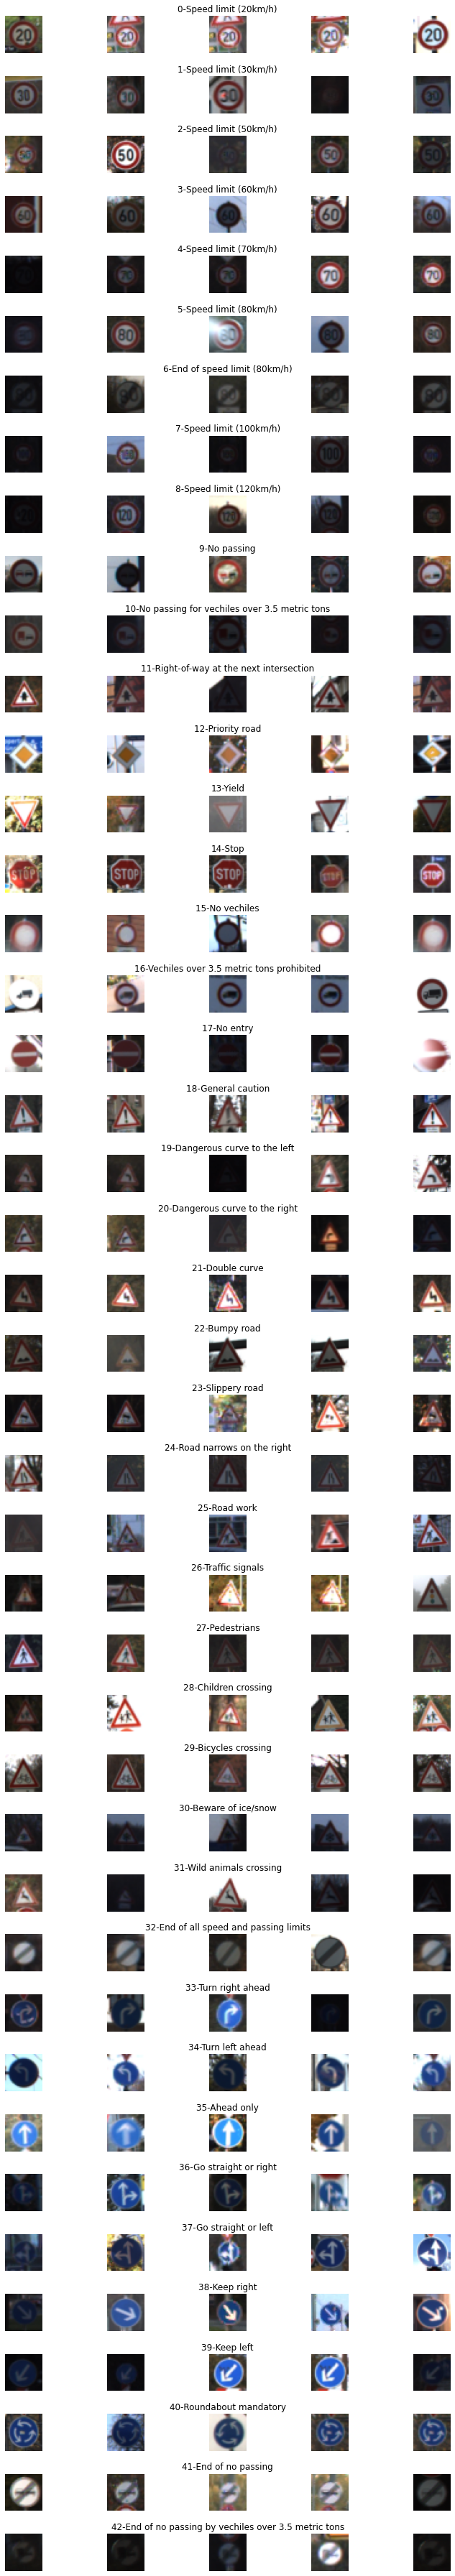

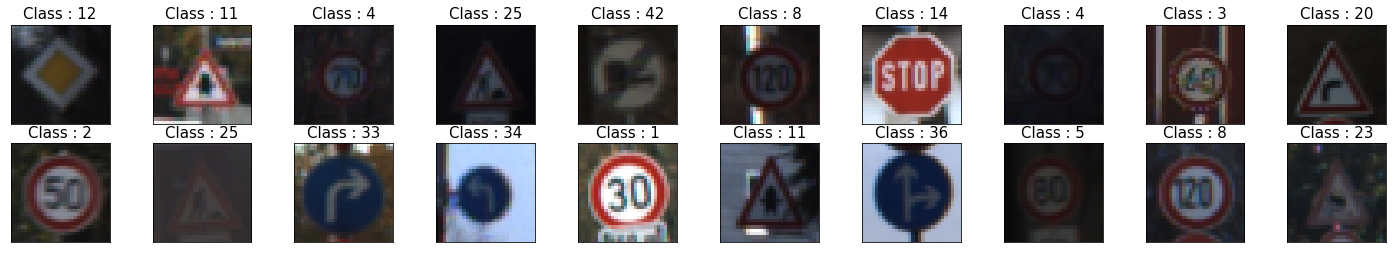

In [12]:
def img_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0) # we reverse the pixels
    image = image * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5]) # denormalization
    image = image.clip(0, 1)
    return image

data_names = pd.read_csv('German-Traffic-Signs-Dataset-GTSRB/signnames.csv')
data = pd.read_csv('German-Traffic-Signs-Dataset-GTSRB/Train.csv')

num_of_samples = []

cols = 5
num_of_classes = 43

fig, axs = plt.subplots(nrows=num_of_classes, ncols=cols, figsize=(10, 50))
fig.tight_layout()


for i in range(cols):
    for j, row in data_names.iterrows():
        x_selected = X_train[y_train == j]
        x_selected = x_selected.squeeze()
        axs[j][i].imshow(img_convert(x_selected[random.randint(0, (len(x_selected) - 1)) ,:, :]), cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))


    
data_iter = iter(train_loader1) # it creates an object that allows us to throw the ittrable training loader one element at a time
images, labels = data_iter.next() # it will grab the first batch of out training data
fig = plt.figure(figsize=(25, 4)) # width & height of the figure ...

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[]) # 2 rows & 10 columns!
    plt.imshow(img_convert(images[idx]).squeeze(), cmap=plt.get_cmap('gray'))
    ax.set_title("Class : " + str(labels[idx].item()), size=15)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


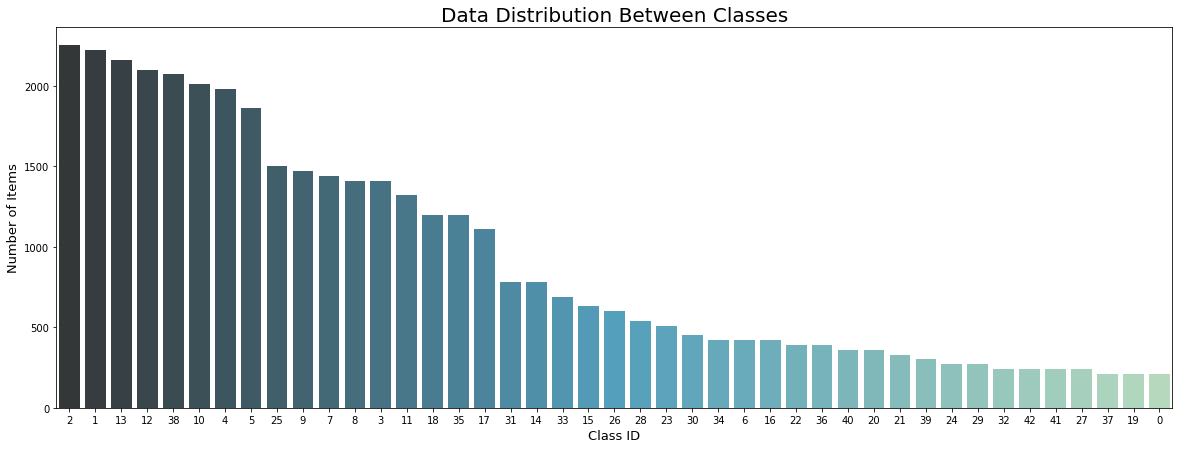

In [13]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(20, 7))
sns.countplot(x='ClassId', data=data, ax=ax, order=data.ClassId.value_counts().index, palette="GnBu_d")
plt.title("Data Distribution Between Classes", fontsize=20, ha='center')
plt.ylabel("Number of Items", fontsize=13)
plt.xlabel("Class ID", fontsize=13)
plt.show()

# **Prepare Data For Training & Testing**

In [14]:
data_test = pd.read_csv('German-Traffic-Signs-Dataset-GTSRB/Test.csv')
data_test

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [0]:
from torch.utils.data.dataset import Dataset
from skimage import io, transform

class GTSDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        data = pd.read_csv(csv_file)
        data = data.drop(columns=['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'])
        self.data = pd.DataFrame(data)
        self.data['Path'] = data['Path'].str.lower()
        self.data['ClassId'] = data['ClassId'].apply(str)

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        pth = self.data.iloc[idx, 1].replace("test/", "")
        img_name = os.path.join(self.root_dir, pth)
        image = io.imread(img_name)
        labels = self.data.at[idx, 'ClassId'] # to access a single item in Pandas DataFrame
        labels = np.array([labels])
        labels = labels.astype('long').reshape(-1, 1)

        sample = [ image, labels]

        if self.transform:
            sample[0] = self.transform(sample[0])
        return sample


class ApplyTransform(Dataset):
    """
    Apply Transformations to a Dataset

    Argumants:

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

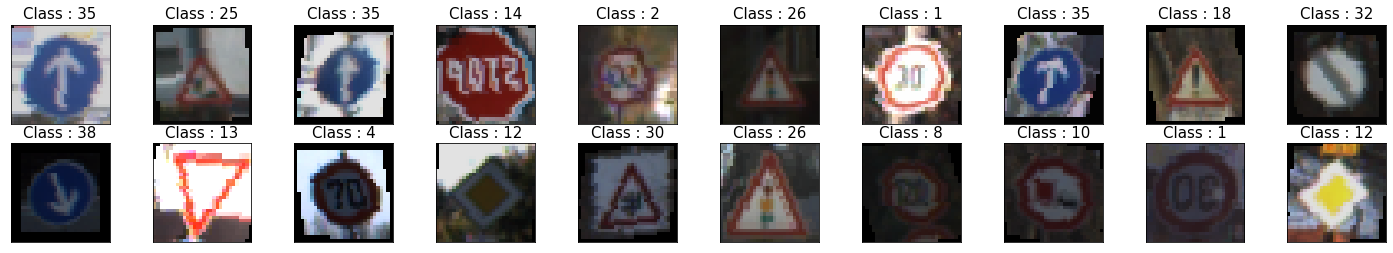

In [16]:
image_size = 30
tfms = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

tfms2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

# For Data Augmentation
train_transforms = transforms.Compose([
                                    #    transforms.ToPILImage(),
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = ImageFolderNew(root=train_dir)


number_of_train = (0.8 * len(train_dataset)).__int__()
number_of_valid = (0.2 * len(train_dataset)).__int__() + 1

data_train, data_valid = random_split(train_dataset, [number_of_train, number_of_valid])

train_dataset = ApplyTransform(data_train, transform=train_transforms)

train_loader_aug = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


data_valid = ApplyTransform(data_valid, transform=tfms)
data_train = ApplyTransform(data_train, transform=tfms)

train_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=data_valid, batch_size=batch_size, shuffle=True)

test_dataset = GTSDataset('German-Traffic-Signs-Dataset-GTSRB/Test.csv', test_dir, transform=tfms2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=300, shuffle=False)
######################################################
data_iter = iter(train_loader_aug) # it creates an object that allows us to throw the ittrable training loader one element at a time
images, labels = data_iter.next() # it will grab the first batch of out training data
fig = plt.figure(figsize=(25, 4)) # width & height of the figure ...

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[]) # 2 rows & 10 columns!
    plt.imshow(img_convert(images[idx]).squeeze(), cmap=plt.get_cmap('gray'))
    ax.set_title("Class : " + str(labels[idx].item()), size=15)

In [0]:
class CnnModelNormal(nn.Module):
    def __init__(self):
        super(CnnModelNormal, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=73, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=73, out_channels=153, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=153, out_channels=273, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(6 * 6 * 273, 500) # 1: Stride
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, 43) # 1: Stride
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        # out = self.softmax(out)
        return out

class CnnModelDropNorm(nn.Module):
    def __init__(self):
        super(CnnModelDropNorm, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=73, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(73),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=73, out_channels=153, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(153),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=153, out_channels=273, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(273),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(6 * 6 * 273, 500) # 1: Stride
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(500, 43) # 1: Stride
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.drop1(out)
        out = self.fc2(out)
        # out = self.softmax(out)
        return out


class CnnModelNorm(nn.Module):
    def __init__(self):
        super(CnnModelNorm, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=73, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(73),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=73, out_channels=153, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(153),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=153, out_channels=273, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(273),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(6 * 6 * 273, 500) # 1: Stride
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, 43) # 1: Stride
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        # out = self.softmax(out)
        return out

In [0]:
import time

def model_training(model=None, epochs=15, optimizer=None, scheduler=None, criterion=nn.CrossEntropyLoss(), train_loader=None):
    start_time = time.time()
    running_loss_history = []
    running_correct_history = []
    val_running_loss_history = []
    val_running_corrects_history = []

    for e in range(epochs):
        running_loss = 0.0
        running_corrects = 0.0
        val_running_loss = 0.0
        val_running_corrects = 0.0
        for inputs, labels in train_loader:
            if torch.cuda.is_available():
                inputs = inputs.to(CUDA)
                labels = labels.to(CUDA)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

            _, preds = torch.max(outputs, 1)
            
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data) # it will give us the number of correct prediction for a single batch of images...

        else:
            with torch.no_grad(): # it will temprerorerly set all the required grad flags to be false
                for val_inputs, val_labels in valid_loader:
                    if torch.cuda.is_available():
                        val_labels = val_labels.to(CUDA)
                        val_inputs = val_inputs.to(CUDA)

                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs, val_labels)

                    _, val_preds = torch.max(val_outputs, 1)
                    val_running_loss += val_loss.item()
                    val_running_corrects += torch.sum(val_preds == val_labels.data)
        
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = running_corrects.float() / len(data_train)
            running_loss_history.append(epoch_loss)
            running_correct_history.append(epoch_acc)

            val_epoch_loss = val_running_loss / len(valid_loader.dataset)
            val_epoch_acc = val_running_corrects.float() / len(data_valid)
            val_running_loss_history.append(val_epoch_loss)
            val_running_corrects_history.append(val_epoch_acc)
            # if (e + 1) % 10 == 0:
            print("Epoch : ", (e+1))
            print('  Training Loss:=> {:.8f},    Training ACC {:.4f} '.format(epoch_loss, epoch_acc.item()))
            print('Validation Loss:=> {:.8f},  Validation ACC {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
            if scheduler is not None:
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("*** Learning Rate : => {:.9f}".format(param_group['lr']))
            print("***->>>-----------------------------------------------<<<-***")

    print("*************************")
    print("--->>> %s seconds <<<---" % (time.time() - start_time))
    print("*************************")
    return running_loss_history, val_running_loss_history, running_correct_history, val_running_corrects_history

In [19]:
from torch.optim.lr_scheduler import MultiStepLR


learning_rate = 0.00073
epochs = 100

criterion = nn.CrossEntropyLoss()

# scheduler_relu = MultiStepLR(optimizer_relu, milestones=[30, 70], gamma=0.1)
####################################################

###########################################################
model_drop_norm = CnnModelDropNorm().to(CUDA)
optimizer_drop_norm = torch.optim.Adam(model_drop_norm.parameters(), lr=learning_rate)
print("### *** Dropout 1 + Batch Normalization : ===>>> *** ###")
train_loss_drop_norm, val_loss_drop_norm, train_acc_drop_norm, val_acc_drop_norm = model_training(model=model_drop_norm, epochs=epochs, optimizer=optimizer_drop_norm, scheduler=None, criterion=criterion, train_loader=train_loader_aug)
###########################################################
model_norm = CnnModelNormal().to(CUDA)
optimizer_norm = torch.optim.Adam(model_norm.parameters(), lr=learning_rate)
print("### *** Normal + Batch Normalization : ===>>> *** ###")
train_loss_norm, val_loss_norm, train_acc_norm, val_acc_norm = model_training(model=model_norm, epochs=epochs, optimizer=optimizer_norm, scheduler=None, criterion=criterion, train_loader=train_loader_aug)
##############################################################
model_normal = CnnModelNormal().to(CUDA)
optimizer_normal = torch.optim.Adam(model_normal.parameters(), lr=learning_rate)
print("### *** Normal : ===>>> *** ###")
train_loss_normal, val_loss_normal, train_acc_normal, val_acc_normal = model_training(model=model_normal, epochs=epochs, optimizer=optimizer_normal, scheduler=None, criterion=criterion, train_loader=train_loader)
##############################################################

### *** Dropout 1 + Batch Normalization : ===>>> *** ###
Epoch :  1
  Training Loss:=> 0.00888609,    Training ACC 0.2682 
Validation Loss:=> 0.00531119,  Validation ACC 0.5099 
***->>>-----------------------------------------------<<<-***
Epoch :  2
  Training Loss:=> 0.00371866,    Training ACC 0.6354 
Validation Loss:=> 0.00216524,  Validation ACC 0.7923 
***->>>-----------------------------------------------<<<-***
Epoch :  3
  Training Loss:=> 0.00199740,    Training ACC 0.8047 
Validation Loss:=> 0.00121801,  Validation ACC 0.8865 
***->>>-----------------------------------------------<<<-***
Epoch :  4
  Training Loss:=> 0.00139236,    Training ACC 0.8656 
Validation Loss:=> 0.00086601,  Validation ACC 0.9188 
***->>>-----------------------------------------------<<<-***
Epoch :  5
  Training Loss:=> 0.00111876,    Training ACC 0.8929 
Validation Loss:=> 0.00073014,  Validation ACC 0.9306 
***->>>-----------------------------------------------<<<-***
Epoch :  6
  Training Loss:=

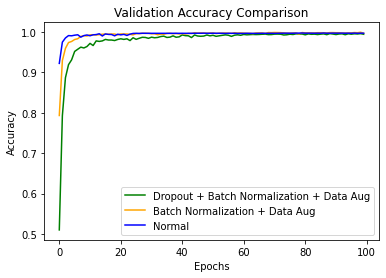

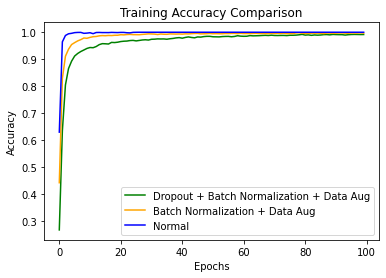

In [24]:
# fig, (ax1, ax2) = plt.subplots(1, 3)
# fig.suptitle('Accuracy Comparison', fontsize=15)
plt.plot(val_acc_drop_norm, label='Dropout + Batch Normalization + Data Aug', color='G')
plt.plot(val_acc_norm, label='Batch Normalization + Data Aug', color='orange')
plt.plot(val_acc_normal, label='Normal', color='B')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison", fontsize=12)
plt.legend()
plt.show()

plt.plot(train_acc_drop_norm, label='Dropout + Batch Normalization + Data Aug', color='G')
plt.plot(train_acc_norm, label='Batch Normalization + Data Aug', color='orange')
plt.plot(train_acc_normal, label='Normal', color='B')
# plt.set(xlabel='x-label', ylabel='y-label')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Comparison", fontsize=12)
plt.legend()
plt.show()

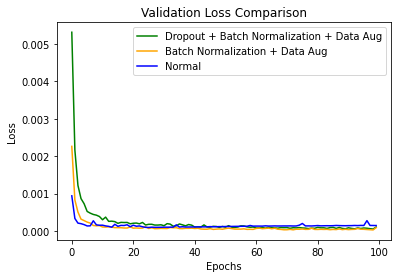

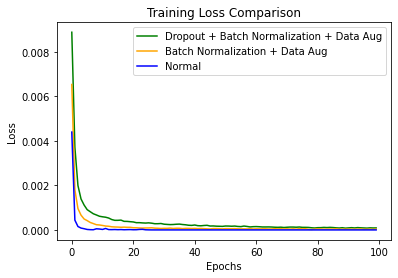

In [25]:
# fig, (ax1, ax2) = plt.subplots(1, 3)
# fig.suptitle('Accuracy Comparison', fontsize=15)
plt.plot(val_loss_drop_norm, label='Dropout + Batch Normalization + Data Aug', color='G')
plt.plot(val_loss_norm, label='Batch Normalization + Data Aug', color='orange')
plt.plot(val_loss_normal, label='Normal', color='B')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss Comparison", fontsize=12)
plt.legend()
plt.show()

plt.plot(train_loss_drop_norm, label='Dropout + Batch Normalization + Data Aug', color='G')
plt.plot(train_loss_norm, label='Batch Normalization + Data Aug', color='orange')
plt.plot(train_loss_normal, label='Normal', color='B')
# plt.set(xlabel='x-label', ylabel='y-label')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison", fontsize=12)
plt.legend()
plt.show()

# **Testing Part**

In [0]:
def test_model(model=None, criterion=None):
    test_running_loss_history = []
    test_running_corrects_history = []
    test_running_loss = 0.0
    test_running_corrects = 0.0

    for test_inputs, test_labels in test_loader:
        # print(test_inputs.shape)
        test_labels = test_labels.view(test_labels.shape[0])
        # print(test_labels.shape)
        if torch.cuda.is_available():
            test_labels = test_labels.to(CUDA)
            test_inputs = test_inputs.to(CUDA)


        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_labels)

        _, test_preds = torch.max(test_outputs, 1)
        test_running_corrects += torch.sum(test_preds == test_labels.data)
        test_running_loss += test_loss.item()
        

    test_epoch_acc = test_running_corrects.float() / len(test_dataset)
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    print("******************************************")
    print('Test Loss: {:.8f},  Test ACC: {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))
    print("******************************************")

In [27]:
print("### *** Dropout + Batch Normalization + Data Aug : ===>>> *** ###")
test_model(model=model_drop_norm, criterion=criterion)
###########################################################
print("### *** Batch Normalization + Data Aug : ===>>> *** ###")
test_model(model=model_norm, criterion=criterion)
##############################################################
##############################################################
print("### *** Normal : ===>>> *** ###")
test_model(model=model_normal, criterion=criterion)

### *** Dropout + Batch Normalization + Data Aug : ===>>> *** ###
******************************************
Test Loss: 0.00078874,  Test ACC: 0.9547 
******************************************
### *** Batch Normalization + Data Aug : ===>>> *** ###
******************************************
Test Loss: 0.00080803,  Test ACC: 0.9581 
******************************************
### *** Normal : ===>>> *** ###
******************************************
Test Loss: 0.00163766,  Test ACC: 0.9580 
******************************************
